In [1]:
import seisbench.models as sbm
import obspy
from obspy.signal.filter import bandpass
from obspy.core.utcdatetime import UTCDateTime
from obspy.signal.trigger import recursive_sta_lta
from obspy_local.obspy_local.io.segy.core import _read_segy
from tqdm import tqdm
import h5py
import torch
import pandas as pd
from scipy.signal import spectrogram, butter, sosfilt, decimate, detrend, resample, resample_poly
from scipy.signal.windows import hann
from scipy.ndimage import gaussian_filter, binary_dilation,label
from scipy.ndimage import sum as imsum
import scipy
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from numpy.fft import rfftn,irfftn,fftfreq,rfftfreq,fftshift,fft2,ifft2
import glob
import matplotlib. pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import datetime as datetime
import pickle
import collections
import multiprocessing
import types
import copy
import struct
import pickle
import time
from PIL import Image
from ELEP.elep.ensemble_coherence import ensemble_semblance
from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.trigger_func import picks_summary_simple
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
import ELEP.elep
from compute_spectrogram import compute_and_plot_spectrogram

In [2]:
def fk(data,fs,dx,cmin,cmax,sgn):

    # get some values
    ns = data.shape[0]
    n = data.shape[1]

    # take rfft
    data_fft = fft2(data)    

    # note that rfft only reduces the fft size for the first dimension, so we use
    # rfftfreq for k0 but fftfreq (with fftshift) for f0
    k0 = fftshift(fftfreq(n,dx))
    f0 = fftshift(fftfreq(ns,1./fs))
    K,F = np.meshgrid(k0,f0)
    C = F/K 
    
    # build filter in fk domain
    filt = np.zeros(data_fft.shape)
    if sgn == "both":
        filt[np.logical_and(((C<-cmin) & (C>-cmax)),((C>cmin) & (C<cmax)))] = 1.
    elif sgn == "neg":
        filt[np.logical_and(C>cmin,C<cmax)] = 1.
    elif sgn == "pos":
        filt[np.logical_and(C<-cmin,C>-cmax)] = 1.

    # smooth filter, apply to transformed data, and invert transform
    filt = gaussian_filter(filt,3) # blur the filter a little to reduce Gibbs ringing
    filt_fft = fftshift(filt)*data_fft
    filt_data = ifft2(filt_fft,s=data.shape).astype('float')
    return filt_data


def normalize_input(sliced_data,mode):
    # normalize by standard deviation
    if mode == "std":
        std_devs = np.expand_dims(np.std(sliced_data,axis=2),axis=2)
        data_norm = np.divide(sliced_data,std_devs)
        data_norm[np.isnan(data_norm)] = 0
    elif mode == "max":
        max_vals = np.expand_dims(np.max(np.abs(sliced_data),axis=2),axis=2)
        data_norm = np.divide(sliced_data,max_vals)
        data_norm[np.isnan(data_norm)] = 0
    return data_norm


def taper(data_norm,taper_len):
    # cosine taper the normalized data
    taper = 0.5 * (1 + np.cos(np.linspace(np.pi, 2 * np.pi, taper_len)))
    data_norm[:,:,:taper_len] *= taper; 
    data_norm[:,:,-taper_len:] *= taper[::-1];
    return data_norm


def apply_model(data_norm,model,eqt,device):
    data_torch = torch.Tensor(data_norm)
    torch_predictions = eqt(data_torch.to(device))
    model_detection_pred = torch_predictions[0].detach().cpu().numpy() # detection
    #model_p_wave_pred = torch_predictions[1].detach().cpu().numpy() # p-wave
    #model_s_wave_pred = torch_predictions[2].detach().cpu().numpy() # s-wave
    return model_detection_pred


def shift_stack(pred_combined,spacing,vel,fs,num_chan):
    delay = spacing/vel
    shift = int(np.floor(delay*fs))
    if shift < 1:
        shift = 1
    migrated_pred = np.zeros((num_chan,6000+shift*num_chan))
    for j in range(num_chan):
        shift_win_start = j*shift
        start_idx = -1-6000-j*shift
        end_idx = -1-j*shift
        migrated_pred[j,start_idx:start_idx+6000] = pred_combined[j,:]

    # fill 0-valued regions with mean
    migrated_pred[migrated_pred == 0] = np.mean(pred_combined[pred_combined!=0])
    #migrated_pred[migrated_pred == 0] = 0

    # sum all p-wave predictions across channel
    condensed_migr_pred = np.sum(migrated_pred,axis=0)

    return condensed_migr_pred


def predict_each_window(reshaped_data,models,eqts,fs,channels,blnd,taper_len,vel):
    
    # get some stuff
    num_chan = channels[1]-channels[0]
    ns_input = 6000 # must be 6000 for eqt model
    
    # make container for the data (nwindow x ncomponent x nsample) and output
    pred_combined = np.ones((num_chan, ns_input), dtype = np.float32) 
    pred = []
    sliced_data = np.zeros((num_chan,3,int(ns_input)),dtype=np.float32)

    # iterate through each window of data
    #for w in [37]:
    for w in range(reshaped_data.shape[0]):

        # reset value of output container
        pred_combined[:,:] = 1

        # put the data into a nwindow x ncomponent x nsample container
        sliced_data[:,:,:] = 0 
        sliced_data[:,1,:] = np.transpose(reshaped_data[w,:,0:channels[1]-channels[0]])

        # normalize by standard deviation
        data_std_norm = normalize_input(sliced_data,"std")
        data_max_norm = normalize_input(sliced_data,"max")

        # cosine taper the normalized data
        data_std_norm = taper(data_std_norm,taper_len)
        data_max_norm = taper(data_max_norm,taper_len)

        # start timer
        #t = time.time()

        # iterate through list of models
        for i,model in enumerate(models):

            # detection
            if model == "original":
                model_det_pred = apply_model(data_std_norm,model,eqts[i],device)
            else:
                model_det_pred = apply_model(data_max_norm,model,eqts[i],device)
            
            # normalize predictions
            pred_det_norm = model_det_pred/np.expand_dims(np.max(np.abs(model_det_pred),axis=(1)),axis=(1))
            #pred_p_norm = model_p_pred/np.expand_dims(np.max(np.abs(model_p_pred),axis=(1)),axis=(1))

            # add to sum of predictions from each model
            pred_combined[:,:] *= pred_det_norm

        # stop timer
        #timer = time.time() - t
        #print("Applied all models in ",timer,"s")

        # zero out edge predictions
        pred_combined[:,:blnd[0]] = 0
        pred_combined[:,-blnd[1]:] = 0

        # align based on a few possible p-wave velocities
        for j,vel in enumerate(vels):
            vel_pred = shift_stack(pred_combined,spacing,vel,fs,num_chan)
            if j == 0:
                max_val = np.max(vel_pred)
                migr_pred = vel_pred
            if j > 0 and np.max(vel_pred) > max_val:
                max_val = np.max(vel_pred)
                migr_pred = vel_pred

        # detrend
        migr_pred = detrend(migr_pred,type="constant")
        migr_pred = detrend(migr_pred)
        
        # add to output
        pred.append(migr_pred)
    return pred


def trigger(predictions,threshold):

    detection_times = []
    detection_predictions = []

    for i in range(len(predictions)):

        # throw away the first 0.5 second window of each file
        predictions[i][0][:] = 0

        for j in range(len(predictions[i])):  
            detections = predictions[i][j] > threshold
            nonzero_detections = detections.nonzero()[0]
            if nonzero_detections.size > 0:
                detection_time = (j*win_len)+nonzero_detections[0]/detections.size*0.5
                detection_times.append(detection_time)
                detection_predictions.append(np.max(predictions[i][j]))
    return detection_times,detection_predictions

In [4]:
'''

Set some parameters

'''

# parameters of the preproccessed data saved as h5
spacing = 1.017
fs = 200
chan_start = 331
channels = [531,1361]
num_chan = channels[1]-channels[0]
chan_pos = (np.array(range(channels[0],channels[1]))-channels[0])*spacing

# fk filtering parameters
cmin = 3000
cmax = np.inf
sgn = "pos"

# windowing parameters
win_len = 0.5 # in seconds
step_len = 0.1 # in seconds
ns_input = 6000 # in samples: must be 6000!
taper_len = 100

# choose the model(s) to run
models = ['original']#, 'ethz']#, 'instance', 'scedc', 'stead']#, 'neic']

# choose a gpu
device = torch.device("cuda")

# choose velocities to test
vels = [4000,6000,8000]

# number of samples to be thrown out on either side of each window of predictions
blnd = [100, 100]

# set output path
out_path = "/home/solinger/detections/eqt_funcs/"

# save every N files
save_n = 1

# set files
path = "/1-fnp/cascadia/c-wsd04/greenland/data/"
files = glob.glob(path+"*")
files.sort()
#fname = "chans331-1360_fs200_2019-07-08T05:42:22-2019-07-08T05:42:51.h5"
#fname = "chans331-1360_fs200_2019-07-07T00:09:22-2019-07-07T00:09:51.h5"
#files = [path+fname]

In [3]:
'''

Run on the entire dataset

'''

# make output container
predictions = []

# start timer
t = time.time()

# initialize the models ahead of time
eqts = []
for i,model in enumerate(models): 
    eqts.append(sbm.EQTransformer.from_pretrained(model))
    eqts[i].to(device)
    eqts[i].eval()

# iterate through each file
for i,f in enumerate(files):
    try:
        print(f)
        #read data
        file = h5py.File(f)
        data = file['data'][()]
        file.close()

        # subset to desired channels
        data = data[:,channels[0]-chan_start:channels[1]-chan_start]

        # fk filter(data,fs,dx,sgn='pos',cmin=5,cmax=50):
        fk_data = fk(data,fs,spacing,cmin,cmax,sgn)

        # set parameters relevant to upsampling
        file_len = data.shape[0]/fs
        fs_new = 6000/win_len
        ns_new = int(file_len * fs_new)
        times = np.arange(0,win_len,1/fs_new)

        # perform upsampling
        #tr = time.time()
        up_data = resample(fk_data,ns_new,axis=0)
        #print("Upsampled in",time.time()-tr,"s")

        # reshape the data
        reshaped_data = np.reshape(up_data,(up_data.shape[0]//6000,6000,up_data.shape[1]))

        # predict each window in the data
        #tp = time.time()
        pred = predict_each_window(reshaped_data,models,eqts,fs_new,channels,blnd,taper_len,vels)
        predictions.append(pred)
        #print("Predicted in",time.time()-tp,"s")

        # save output
        if np.mod(i+1,save_n) == 0:

            # save result for this file
            t = time.time()
            start_str = files[i+1-save_n].split("200_")[1].split("-2019")[0]
            end_str = "2019" + files[i].split("200_")[1].split("-2019")[1].split(".")[0]
            fname = (out_path+start_str+"-"+end_str+".pickle")

            # save array of data to h5
            with open(fname, "wb") as output_file:
                pickle.dump(predictions, output_file)

            # reset output container
            predictions = []
            print("saved in",time.time()-t)
    except:
        pass

# stop timer
timer = time.time() - t
print("Did workflow in",timer,"s")

NameError: name 'models' is not defined

In [ ]:
'''

Investigate results for a particular file

'''

# choose a datetime
datestring = "2019-07-06T12:03:21"

# list the output files
out_file = glob.glob(out_path+"/"+datestring+"*")[0]
with open(out_file, "rb") as f:
    predictions = pickle.load(f)

# get some data
file_ind = [datestring in f for f in files]
data_file = np.array(files)[file_ind][0]
file = h5py.File(data_file)
data = file['data'][()]
file.close()

In [ ]:
'''

Threshold all the predictions into detections

'''

# list the output files
out_files = glob.glob(out_path+"/*2019*")
    
# set the threshold
threshold = 50

# trigger the detector
all_detections = []
all_detection_predictions = []
for out_file in out_files:
    with open(out_file, "rb") as f:
        predictions = pickle.load(f)
    detections,detection_predictions = trigger(predictions,threshold)
    if len(detections) > 0:
        fdate = datetime.datetime.strptime(out_file.split("funcs/")[1].split("-2019")[0],"%Y-%m-%dT%H:%M:%S")
        detection_times = [fdate + datetime.timedelta(seconds=s) for s in detections]
        all_detections.append(detection_times)
        all_detection_predictions.append(detection_predictions)

In [ ]:
'''

Save the times of all triggered detections

'''

# save detection times
det_file = out_path + "detection_times.pickle"
with open(det_file, "wb") as output_file:
    pickle.dump(all_detections, output_file)
    
# save summed prediction values for each detection time
det_pred_file = out_path + "detection_predictions.pickle"
with open(det_pred_file, "wb") as output_file:
    pickle.dump(all_detection_predictions, output_file)

In [ ]:
'''

Plot all the events

'''

# set some plotting parameters
pre_buff = 0.2
post_buff = 0.3

# set output path
fig_path = "/home/solinger/detections/eqt_plots/"

# iterate through each detection
for f in files:
    
    # get time lims of the file
    file_start = datetime.datetime.strptime(f.split("200_")[1].split("-2019")[0],"%Y-%m-%dT%H:%M:%S")    
    file_end = file_start + datetime.timedelta(seconds=29)

    # find corresponding list of detections
    detection_bool = np.where([det[0] > file_start and det[0] < file_end for det in all_detections])

    # if there are detections in this file
    if len(detection_bool[0]) > 0:
        detection_ind = detection_bool[0][0] 
        detection_times = all_detections[detection_ind]
        max_predictions = all_detection_predictions[detection_ind]
        
        # read the file
        file = h5py.File(f)
        data = file['data'][()]
        file.close()

        # plot each event
        for i,d in enumerate(detection_times):

            # get window start times
            d_sec = d-file_start
            win_start_sec = d_sec.total_seconds()-pre_buff
            win_starttime = file_start + datetime.timedelta(seconds=win_start_sec)
            win_end_sec = d_sec.total_seconds()+post_buff
            win_endtime = file_start + datetime.timedelta(seconds=win_end_sec)
            
            # window the data
            win_start = int(np.floor(fs*win_start_sec))
            win_end = int(np.floor(fs*win_end_sec))
            win_data = data[win_start:win_end,:]
            t = pd.date_range(start=win_starttime,end=win_endtime,periods=win_data.shape[0])
            
            # make the plot
            fig, ax = plt.subplots(figsize=(10,7))
            ax.pcolormesh(t,np.array(range(0,channels[1]-331))*spacing,np.transpose(win_data),cmap='gray',vmin=-50,vmax=50)
            plt.gca().invert_yaxis()
            ax.set_ylabel("Depth (m)")
            ax.set_xlabel("Time (s)")
            ax.set_ylim(channels[1]-331,0)
            ax.vlines(d,ymin=331,ymax=channels[1],colors='r',linestyle="-",alpha=0.35)
            title = ("Detection at " + d.strftime("%Y-%m-%dT%H:%M:%S") + 
                     " ($\Sigma P$ = " + str(np.round(max_predictions[i],1))+ ")")
            ax.set_title(title)
            
            # save figure
            fname = fig_path+d.strftime("%Y-%m-%dT%H:%M:%S")+"_P"+str(np.round(max_predictions[i],1))+".png"
            plt.savefig(fname)
            plt.close()

In [ ]:
'''

Use STALTA on the event windows to determine (very) approximate depths

'''

# SAVE MEAN AMPLITUDE OVER MASKED REGION

# set some windowing parameters
pre_buff = 0.4
post_buff = 0.3

# set stalta lengths (samples)
sta = 5
lta = 40

# fk filtering parameters
cmin = 3000
cmax = np.inf
sgn = "pos"

# set threshold for image region size (minumum size to qualify as a moveout)
size_thresh = 400

# load detection times and predictions
det_file = out_path + "detection_times.pickle"
with open(det_file, "rb") as f:
    all_detections = pickle.load(f)
pred_file = out_path + "detection_predictions.pickle"
with open(pred_file, "rb") as f:
    all_predictions = pickle.load(f)

# make dataframe for storing
df = pd.DataFrame(columns=["detection time","times","first channel", "channels"])

# iterate through each detection
for f in files:
    
    # get time lims of the file
    file_start = datetime.datetime.strptime(f.split("200_")[1].split("-2019")[0],"%Y-%m-%dT%H:%M:%S")    
    file_end = file_start + datetime.timedelta(seconds=29)

    # find corresponding list of detections
    detection_bool = np.where([det[0] > file_start and det[0] < file_end for det in all_detections])

    # if there are detections in this file
    if len(detection_bool[0]) > 0:
        detection_ind = detection_bool[0][0] 
        detection_times = all_detections[detection_ind]
        max_predictions = all_predictions[detection_ind]
        
        # read the file
        file = h5py.File(f)
        data = file['data'][()]
        file.close()

        # plot each event
        for i,d in enumerate(detection_times):

            # get window start times
            d_sec = d-file_start
            win_start_sec = d_sec.total_seconds()-pre_buff
            win_starttime = file_start + datetime.timedelta(seconds=win_start_sec)
            win_end_sec = d_sec.total_seconds()+post_buff
            win_endtime = file_start + datetime.timedelta(seconds=win_end_sec)
            
            # window the data
            win_start = int(np.floor(fs*win_start_sec))
            win_end = int(np.floor(fs*win_end_sec))
            win_data = data[win_start:win_end,:]
            t = pd.date_range(start=win_starttime,end=win_endtime,periods=win_data.shape[0])

            # fk filter the data
            win_data = fk(win_data,fs,spacing,cmin,cmax,sgn)

            # run stalta
            argmax_im = np.zeros(win_data.shape)
            for c in range(win_data.shape[1]):
                stalta = recursive_sta_lta(win_data[:,c],sta,lta)
                argmax_im[np.argmax(stalta),c] = 1

            # dilate binary image to connect moveout regions
            k = np.ones((2,15))
            argmax_im = binary_dilation(argmax_im,structure=k)

           # get rid of non-contiguous regions
            id_regions, num_ids = label(argmax_im)
            id_sizes = np.array(imsum(argmax_im, id_regions, range(num_ids + 1)))
            area_mask = (id_sizes < size_thresh)
            argmax_im[area_mask[id_regions]] = 0 

            # get first arrival channel and time of each moveout
            id_regions, num_ids = label(argmax_im)
            for i in range(1,num_ids+1):
                region_im = copy.deepcopy(argmax_im)
                region_im[np.array(id_regions != i)] = 0
                masked_moveout = win_data*region_im
                mean_amplitude = np.mean(np.abs(masked_moveout != 0))
                moveout_channels = 331+np.where(region_im)[1]
                moveout_times = t[np.where(region_im)[0]]
                out_data = [[moveout_times[0],moveout_times,moveout_channels[0],moveout_channels,mean_amplitude]]
                temp_df = pd.DataFrame(out_data,columns=["detection time","times","first channel", "channels","mean amplitude"])
                df = pd.concat([df,temp_df],ignore_index=True)
                
# save the resulting catalog
df.to_pickle("/home/solinger/detections/processed_eqt_detections.pickle")

/tmp/ipykernel_1212646/2346519405.py:15: RuntimeWarning: divide by zero encountered in divide
  C = F/K
/tmp/ipykernel_1212646/2346519405.py:15: RuntimeWarning: invalid value encountered in divide
  C = F/K
/tmp/ipykernel_1212646/2346519405.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  filt_data = ifft2(filt_fft,s=data.shape).astype('float')


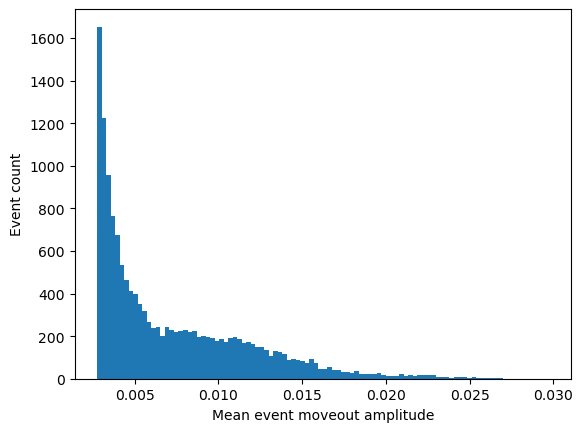

In [153]:
'''

Plot distribution of mean icequake amplitudes

'''

# load detection times and predictions
det_file = "/home/solinger/detections/processed_eqt_detections.pickle"
with open(det_file, "rb") as f:
    df = pickle.load(f)
    
# get icequake apparent depths and detection times
depths = (np.array(df["first channel"].to_list())-331)*spacing
detection_times = np.array(df["detection time"].to_list())
mean_amplitudes = np.array(df["mean amplitude"].to_list())

# make a histrogram
plt.hist(mean_amplitudes,bins=100)
plt.xlabel("Mean event moveout amplitude")
plt.ylabel("Event count")
#plt.xscale("log")
plt.show()

/tmp/ipykernel_1270489/4162132455.py:39: UserWarning: Discarding nonzero nanoseconds in conversion.
  detections_datenum = [d.to_pydatetime().timestamp() for d in spacing_times]


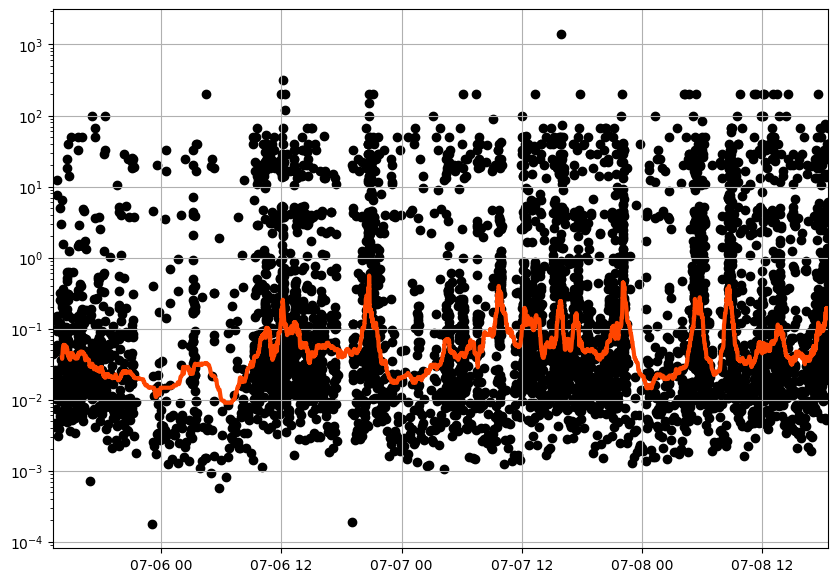

In [46]:
'''

Investigate event timing

'''

# set depth bounds 
spacing = 1.017
depth_upper = 500
depth_lower = 1200

# load detection times and predictions
det_file = "/home/solinger/detections/processed_eqt_detections.pickle"
with open(det_file, "rb") as file:
    df = pickle.load(file)
    
# get icequake apparent depths and detection times
depths = (np.array(df["first channel"].to_list())-331)*spacing
detection_times = np.array(df["detection time"].to_list())
        
# filter by apparent depth
filtered_detection_times = []
for i,d in enumerate(detection_times):
    if depths[i] < depth_lower and depths[i] > depth_upper:
        filtered_detection_times.append(d)
filtered_detection_times = np.array(filtered_detection_times)
    
# take difference in event times
event_spacing = np.diff(filtered_detection_times)
event_spacing = np.array([e.total_seconds() for e in event_spacing])

# remove 0 spacing values (double counted events)
spacing_times = filtered_detection_times[1:][event_spacing != 0]
event_spacing = event_spacing[event_spacing != 0]

# apply a moving average filter TRY MEDIAN, or just LPF
mean_win_size = 100
smoothed_spacing = np.median(sliding_window_view(event_spacing, mean_win_size),axis=-1)
detections_datenum = [d.to_pydatetime().timestamp() for d in spacing_times]
smoothed_detections_datenum = sliding_window_view(detections_datenum, mean_win_size).mean(axis=-1)
smoothed_detections = [datetime.datetime.fromtimestamp(d) for d in smoothed_detections_datenum]

# get freq for both
freq = [1/e for e in event_spacing]
smoothed_freq = [1/e for e in smoothed_spacing]

# plot the recurrence info
fix,ax = plt.subplots(figsize=(10,7))
ax.scatter(spacing_times,freq,c='black')
ax.set_yscale("log")
ax.plot(smoothed_detections,smoothed_freq,c='orangered',linewidth=3)
ax.set_yscale("log")
ax.grid(True)
ax.set_xlim(filtered_detection_times[0],filtered_detection_times[-1])
plt.show()

In [47]:
'''

Compute a spectrogram for data from one channel

'''

# set channel
spec_chan = 601

# get list of all continuous data file for that channel
path = "/1-fnp/pnwstore1/p-wd05/greenland/data/channel/"
files = glob.glob(path+"/*")
file_idx = np.where([str(spec_chan) in f for f in files])[0][0]
file = files[file_idx]

# set parameters
window_length = 1000 # seconds
noverlap = 0.75 # ratio of window_length

# read the file
st = obspy.read(file)
fs = st[0].stats.sampling_rate

# filter
st.filter("bandpass",freqmin=1/window_length,freqmax=0.49*fs)

# make a spectrogram
f,t,s = spectrogram(st[0].data, fs=fs, nperseg=int(fs*window_length),
                    noverlap=(np.round(noverlap*fs*window_length)))

/tmp/ipykernel_1270489/3481816887.py:26: RuntimeWarning: divide by zero encountered in log10
  spec = ax.pcolorfast(datenums, np.log10(f[1:]), np.log10(s[2:,1:]),vmin=-1,vmax=2)


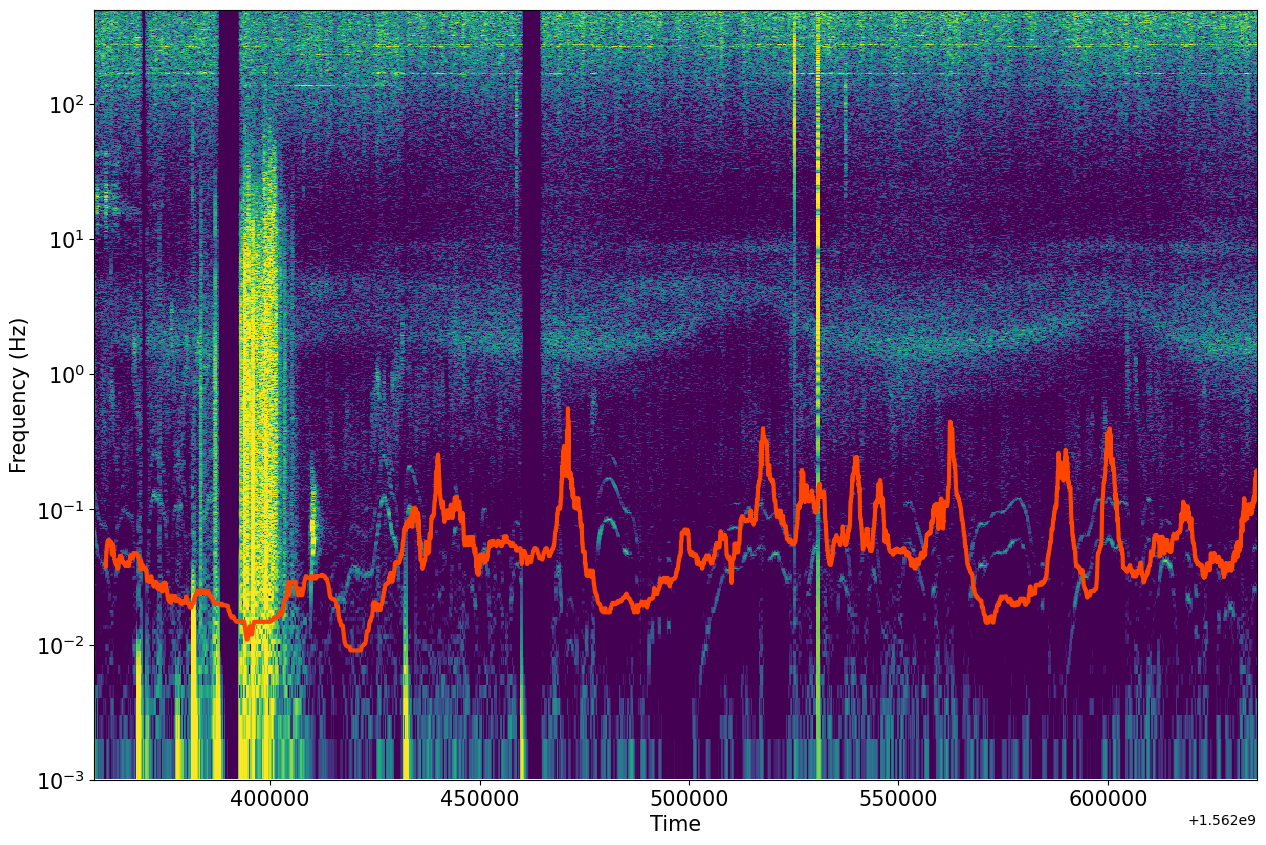

In [48]:
'''

Plot spectrogram of data with recurrence times

'''

# make a plot
fig,ax = plt.subplots(figsize=(15,10))

# plot spectrogram
starttime = st[0].stats.starttime
endtime = st[0].stats.endtime
hours = np.floor((endtime-starttime)/(6*3600))+1
ticks = [starttime.datetime + datetime.timedelta(seconds=hour*6*3600) for hour in range(int(hours))]
times = [starttime.datetime + datetime.timedelta(seconds=time) for time in t]
datenums = [t.timestamp() for t in times]

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d \n %H:%M'))
#ax.set_xticks(ticks)
ax.tick_params(axis='both', which='major', labelsize=15)
#ax.set_xlim([times[0]-datetime.timedelta(seconds=10),times[-1]+datetime.timedelta(seconds=10)])
ax.set_yticks([-3,-2,-1,0,1,2,3])
ax.set_yticklabels(["$10^{-3}$","$10^{-2}$","$10^{-1}$","$10^{0}$","$10^{1}$","$10^{2}$","$10^{3}$"],fontsize=15)
ax.set_ylabel("Frequency (Hz)",fontsize=15)
ax.set_xlabel("Time",fontsize=15)
spec = ax.pcolorfast(datenums, np.log10(f[1:]), np.log10(s[2:,1:]),vmin=-1,vmax=2)

# plot recurrence on top
ax.plot(smoothed_detections_datenum,np.log10(smoothed_freq),c='orangered',linewidth=3)
plt.show()

In [ ]:
'''

Visualize the catalog

'''

# get icequake apparent depths and detection times
depths = (np.array(df["first channel"].to_list())-331)*spacing
detection_times = df["detection time"].to_list()

# plot depth and time
fig,ax = plt.subplots(figsize=(15,7))
ax.grid(True)
plt.scatter(df["detection time"].to_list(),depths,s=4,c=depths)
plt.plasma()
plt.gca().invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Time (s)")
ax.set_ylim(channels[1]-331,0)
ax.set_xlim(detection_times[0],detection_times[-1])
plt.show()

# zoomed plot depth and time
fig,ax = plt.subplots(figsize=(15,7))
ax.grid(True)
plt.scatter(detection_times,depths,s=10,c=depths)
plt.plasma()
plt.gca().invert_yaxis()
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Time (s)")
ax.set_ylim(channels[1]-331,0)
start_stamp = datetime.datetime(2019,7,8,5)
end_stamp = datetime.datetime(2019,7,8,6,15)
ax.set_xlim(start_stamp,end_stamp)
plt.show()